# Run ART with one-hot encoding of input variables

First import ART package:

In [20]:
import sys
sys.path.append('../AutomatedRecommendationTool')
    
from art.core import *
import pickle

All genes we might consider in relation to isopentenol production:

In [10]:
reactions = ['ACCOAC', 
             'MDH',
             'PTAr', 
             'CS', 
             'ACACT1r', 
             'PPC', 
             'PPCK', # zero flux
             'PFL'] # zero flux, can be forced


In [11]:
data_file = './data/training_data_8reactions_iso.csv'
df = pd.read_csv(data_file)
df.head()

,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Isoprenol [mM]
0,1,1,1,2,0,2,0,0,0,0.000000
1,2,1,2,2,2,2,1,1,0,0.208611
2,3,1,0,0,2,1,1,2,0,0.309396
3,4,1,1,1,1,2,2,1,0,0.715185
4,5,2,0,2,1,1,0,1,1,0.118605


In [12]:
df[df['Line Name']=='WT']['Isoprenol [mM]']

95    0.552325
Name: Isoprenol [mM], dtype: float64

Text(0.5, 0, 'strains')

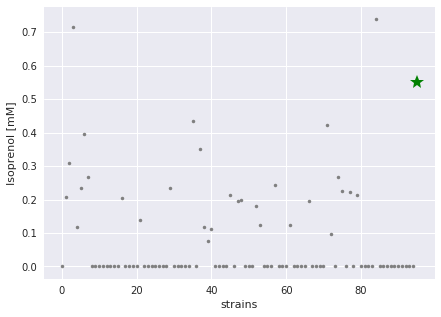

In [13]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.plot(df['Isoprenol [mM]'],'.',color='grey')
ax.plot(95,df[df['Line Name']=='WT']['Isoprenol [mM]'],'g*',markersize=15)
ax.set_ylabel('Isoprenol [mM]')
ax.set_xlabel('strains')

One hot encode variables

In [14]:
df_oneh = pd.get_dummies(data=df, columns=reactions)
df_oneh.head()

,Line Name,Isoprenol [mM],ACCOAC_0,ACCOAC_1,ACCOAC_2,MDH_0,MDH_1,MDH_2,PTAr_0,PTAr_1,...,ACACT1r_2,PPC_0,PPC_1,PPC_2,PPCK_0,PPCK_1,PPCK_2,PFL_0,PFL_1,PFL_2
0,1,0.000000,0,1,0,0,1,0,0,0,...,1,1,0,0,1,0,0,1,0,0
1,2,0.208611,0,1,0,0,0,1,0,0,...,1,0,1,0,0,1,0,1,0,0
2,3,0.309396,0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,1,1,0,0
3,4,0.715185,0,1,0,0,1,0,0,1,...,1,0,0,1,0,1,0,1,0,0
4,5,0.118605,0,0,1,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


Store colnames as parameter setting for ART

In [15]:
colnames = df_oneh.columns[2:].tolist()

Pivot dataframe and change column names

In [16]:
df_oneh = df_oneh.set_index('Line Name').stack().reset_index()
df_oneh.columns = ['Line Name', 'Measurement Type', 'Value']
df_oneh.head()

,Line Name,Measurement Type,Value
0,1,Isoprenol [mM],0.0
1,1,ACCOAC_0,0.0
2,1,ACCOAC_1,1.0
3,1,ACCOAC_2,0.0
4,1,MDH_0,0.0


## Train ART

Assign ART parameters:

In [17]:
art_params = {}
art_params['response_var'] = ['Isoprenol [mM]']
art_params['input_var'] = colnames
art_params['seed'] = 10  
art_params['num_recommendations'] = 96   
art_params['cross_val'] = True
art_params['recommend'] = False
art_params['output_directory'] = './results_onehot/'

Run ART with seed (takes around 3h) or load previously run model.

In [18]:
run_art = False

In [21]:
%%time
if run_art:
    art = RecommendationEngine(df_oneh, **art_params)
else:
    with open('results_onehot/art.pkl', 'rb') as output:
        art = pickle.load(output)

CPU times: user 336 ms, sys: 60 ms, total: 396 ms
Wall time: 1.43 s


In [22]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.170324,inf,0.162852,0.055531,-1.358838
Random Forest Regressor,0.041294,NaN,0.072102,0.006904,0.706740
TPOT Regressor,0.034995,NaN,0.080377,0.007685,0.673550
Support Vector Regressor,0.109145,inf,0.089238,0.019876,0.155713
Kernel Ridge Regressor,0.084722,inf,0.121814,0.022017,0.064786
K-NN Regressor,0.089582,NaN,0.109281,0.019967,0.151834
Gaussian Process Regressor,0.083255,inf,0.093208,0.015619,0.336538
Gradient Boosting Regressor,0.064239,inf,0.083234,0.011055,0.530423
Ensemble Model,0.041780,inf,0.073933,0.007212,0.693662


In [24]:
# os.rename(art.outDir + '/metric0.csv', art.outDir + '/metric.csv')
os.rename(art.outDir + '/cv_metric0.csv', art.outDir + '/cv_metric.csv')

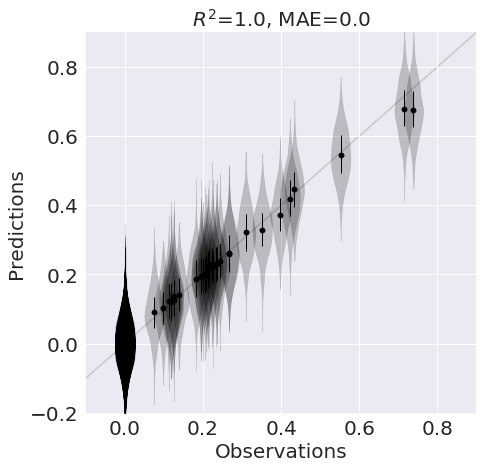

In [39]:
plot.predictions_distr_vs_observations(art, cv_flag=False, 
                                       xlim=[[-0.1, 0.9]], ylim=[[-0.2, 0.9]],
                                       widths=0.05)

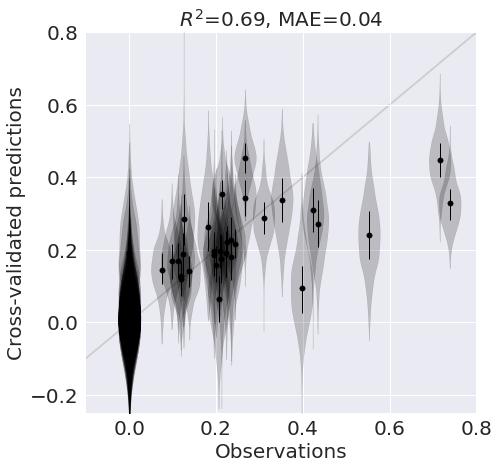

In [38]:
plot.predictions_distr_vs_observations(art, cv_flag=True, 
                                       xlim=[[-0.1, 0.8]], ylim=[[-0.25, 0.8]],
                                       widths=0.05)

In [33]:
utils.save_pkl_object(art)
